In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from math import *

file = "R1B9_RvsT_coated_0T_5mV.xlsx"
sheet_name="R_vs_T_R1B92_0T_5mV"
df = pd.read_excel(file, sheet_name=sheet_name)
# filter out negative currents for fitting purposes
df = df[df.Current != "--"]
df = df[df.Current > 0]

df = df[df.Voltage != "--"]
df = df[df.Temp != "--"]
# look at only low conductances to improve our fit
# df = df.query("Current < 7.5e-10")
temp, current, voltage = df["Temp"], df["Current"], df["Voltage"]


file = "R2B8_RvsT_coated_5mV.xlsx"
sheet_name2="R2B8_5mV_0T"
df2 = pd.read_excel(file, sheet_name=sheet_name2)
# filter out negative currents for fitting purposes
df2 = df2[df2.Current != "--"]
df2 = df2[df2.Current > 0]

df2 = df2[df2.Voltage != "--"]
df2 = df2[df2.Temp != "--"]
# look at only low conductances to improve our fit
# df = df.query("Current < 1e-9")
temp2, current2, voltage2 = df2["Temp"], df2["Current"], df2["Voltage"]


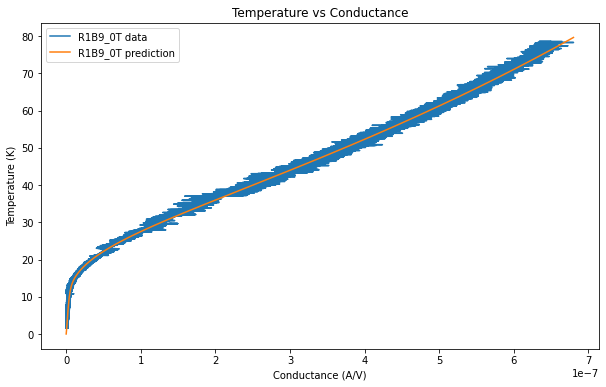

                                            np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)
Coefficients for R1B9_0T              [2.96996743e+08 1.07359297e+03 2.33900127e-01 1.05933252e+06]
Coefficients for R2B8_5mV_0T          [3.34539242e+08 1.35427787e+03 2.03408081e-01 3.12962671e+06]


In [180]:
conductance = current/voltage
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(conductance,temp, label="{} data".format(sheet_name))
plt.xlabel("Conductance (A/V)")
plt.ylabel("Temperature (K)")

conductance2 = current2/voltage2
# plt.plot(conductance2,temp2, label="{} data".format(sheet_name2))


def conductance_to_temp_fit(x, a, b, c, d):
    return np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)
coeffs, cov = curve_fit(conductance_to_temp_fit, np.array(conductance), np.array(temp)
                        , bounds=((0,0,0,0),(np.inf,np.inf,1,np.inf))
                        , p0=[3.34539242e+08, 1.35427786e+03, 2.48389972e-01, 1.12962671e+06])

coeffs2, cov2 = curve_fit(conductance_to_temp_fit, np.array(conductance2), np.array(temp2)
                        , bounds=((0,0,0,0),(np.inf,np.inf,1,np.inf))
                        , p0=[3.34539242e+08, 1.35427786e+03, 2.48389972e-01, 3.12962671e+06])

err = np.sqrt(np.diag(cov))
err2 = np.sqrt(np.diag(cov2))
a,b,c,d = coeffs
# default args used to store values and make a closure
cond_to_temp  = lambda x, a=a, b=b, c=c, d=d: conductance_to_temp_fit(x,a,b,c,d)
a,b,c,d = coeffs2
cond_to_temp2 = lambda x, a=a, b=b, c=c, d=d: conductance_to_temp_fit(x,a,b,c,d)

domain = np.linspace(min(conductance), max(conductance), 1000)
fitted_temps = [cond_to_temp(c) for c in domain]
plt.plot(domain, fitted_temps, label="{} prediction".format(sheet_name))


domain2 = np.linspace(min(conductance2), max(conductance2), 1000)
fitted_temps2 = [cond_to_temp2(c) for c in domain2]
# plt.plot(domain2, fitted_temps2, label = "{} prediction".format(sheet_name2))

plt.title("Temperature vs Conductance")
plt.legend()


plt.savefig("graphs/Temperature vs Conductance for 5mV R1B9 0T")
plt.show()
print(" "*44+"np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)")
print("Coefficients for {:<20}".format(sheet_name), coeffs)
print("Coefficients for {:<20}".format(sheet_name2), coeffs2)


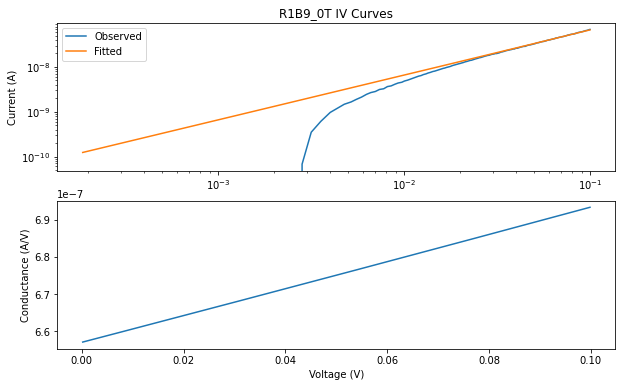

[1e-10, 1.97e-08, 1.79e-07, 6.57e-07, 5e-21]


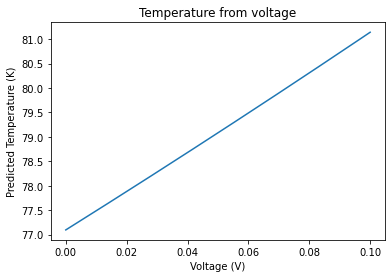

Prediction for 5mV: 77.29103542296788
Prediction for 0.2V: 85.48600529721419


In [193]:
def plot_IV_curve_simple(file, sheet_name, axs=None, silent=False, voltage_upper_bound=None):
    """
    :param file: Name of the file to read from
    :param sheet_name: Name of the sheet in the file
    :param axs: Optional argument with axs to plot on
    """
    df = pd.read_excel(file, sheet_name=sheet_name)
    df = df.query("Voltage > 0")
    if voltage_upper_bound != None:
        df = df.query("Voltage < {}".format(voltage_upper_bound))
    if silent:
        return df['Voltage'], df['Current']

    if axs == None:
        axs = plt.axes()

    axs.plot(df['Voltage'], df['Current'])
    axs.set_xlabel("Voltage")
    axs.set_ylabel("Current")
    axs.set_title("Voltage-Current curve for {}".format(sheet_name))
    return df['Vsd'], df['Current']

sheet_name = "R1B9_0T"
voltages, currents = plot_IV_curve_simple("5_3_21-IVs_at_100K-0Tvs7T.xlsx"
                                          , sheet_name=sheet_name, silent = True, voltage_upper_bound=0.1)

# force positive fitting coeffs so deriv is positive always
def fit_fun(x, a, b, c, d, f):
    return a * x ** 4 \
           + b * x ** 3 + c * x ** 2 + d * x + f

p, _ = curve_fit(fit_fun, voltages, currents,
                 bounds = [(0,0,0,0,0),(np.inf,np.inf,np.inf,np.inf,1e-20)],
                 p0 = [5e-16, 1.97e-08, 1.79e-07, 6.57e-07, 4.99e-21])
p = list(p)
outputs = np.polyval(p, voltages)

derivs = np.polyder(p)
deriv_outputs = np.polyval(derivs, voltages)
fig, axs = plt.subplots(2, figsize=(10, 6))
axs[0].set_title("{} IV Curves".format(sheet_name))
axs[1].set_xlabel("Voltage (V)")
axs[0].plot(voltages, currents, label="Observed")
axs[0].plot(voltages, outputs, label="Fitted")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_ylabel("Current (A)")

axs[1].plot(voltages, deriv_outputs)
axs[1].set_ylabel("Conductance (A/V)")
plt.savefig("graphs/R1B9 100K IV Curves and Conductance")
plt.show()
print(p)


# now try to compute temperature from a given voltage
# plot voltages from 0 to 1
domain = np.linspace(0,0.1,50000)
conductances = np.polyval(derivs, domain)
temps = cond_to_temp(conductances)
plt.plot(domain, temps)
plt.xlabel("Voltage (V)")
plt.ylabel("Predicted Temperature (K)")
plt.title("Temperature from voltage")
plt.savefig("graphs/Predicted temperature from voltage")
plt.show()

print("Prediction for 5mV: {}".format(cond_to_temp(np.polyval(derivs,5/1000))))
print("Prediction for 0.2V: {}".format(cond_to_temp(np.polyval(derivs,0.2))))